In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def convert2_bin(state_number, N):
    binary = bin(state_number)[2:]
    return "0"*(N-len(binary))+binary



In [23]:
convert2_bin(2,3)


'010'

In [24]:
def ising_operator(state_vector, J=12, g=100):
    N = int(np.log2(len(state_vector)))
    resulting_vector = np.zeros(state_vector.shape,dtype=np.complex_)
    for state_number in range(len(state_vector)):
        half_result_vector = np.zeros(state_vector.shape,dtype=np.complex_)
        if state_vector[state_number] == 0:
            continue
        
        binary = convert2_bin(state_number, N)
        a = 0
        
        for i in range(len(binary)-1):
            a += 1 if binary[i]==binary[i+1] else -1
        half_result_vector[state_number] = J*a
        
        for i in range(len(binary)):
            new_binary = binary[:i] + str(int(binary[i]=="0")) + binary[i+1:]
            half_result_vector[int(new_binary, 2)] = -g
            
        resulting_vector += state_vector[state_number]*half_result_vector
    return resulting_vector
    

In [25]:
ising_operator(np.array([0,0,1,0,0,0,0,0]))

array([-100.+0.j,    0.+0.j,  -24.+0.j, -100.+0.j,    0.+0.j,    0.+0.j,
       -100.+0.j,    0.+0.j])

In [26]:
def hamiltonian_matrix(N,J,g):
    v_ising_operator = np.vectorize(ising_operator,signature='(n),(),()->(n)')
    return v_ising_operator(np.eye(2**N),J,g)

In [27]:
def hamiltonian_elements(N,state, J=1, g=2):
    Hs = ising_operator(np.eye(2**N)[state], J, g)
    result = []
    for i in range(len(Hs)):
        if Hs[i] == 0:
            continue
        result.append((Hs[i],i))
    return result
    

In [28]:
hamiltonian_elements(3,0)

[((2+0j), 0), ((-2+0j), 1), ((-2+0j), 2), ((-2+0j), 4)]

In [112]:
def make_it_complex(a,b,W):
    a_z = a[:len(a)//2] + 1j * a[len(a)//2:]
    b_z = b[:len(b)//2] + 1j * b[len(b)//2:]
    W_z = W[:len(W)//2] + 1j * W[len(W)//2:]
    return a_z, b_z, W_z

def rbm_phi(s, a, b, W):
    a_z, b_z, W_z = make_it_complex(a,b,W)
    c = np.dot(a_z, s)
    d = 1
    for i in range(len(b_z)):
        d *= np.cosh(b_z[i] + np.dot(W_z[i], s))
    return np.exp(c) * d

def rbm_phi_flat(s, a, b, W):
    W = np.reshape(W, (len(b), len(s)))
    return rbm_phi(s, a, b, W)

def o_der_a(s, a, b, W):
    return np.concatenate((s,1j*s))

def o_der_b(s, a, b, W):
    a_z, b_z, W_z = make_it_complex(a,b,W)
    r = np.array([np.tanh(b_z[i] + np.dot(W_z[i], s)) for i in range(len(b_z))])
    return np.concatenate((r,1j*r))

def o_der_W(s, a, b, W):
    a_z, b_z, W_z = make_it_complex(a,b,W)
    r = np.array([[s[k] * np.tanh(b_z[i] + np.dot(W_z[i], s)) for k in range(len(W_z[0]))] for i in range(len(W_z))])
    return np.concatenate((r,1j*r))

def rbm_phi_theta(s, theta):
    n = len(s)
    m = (len(theta) - 2*n) // (n+1)
    a = theta[:2*n]
    b = theta[2*n:2*n+m]
    W = np.reshape(theta[2*n+m:], (m, n))
    return rbm_phi(s, a, b, W)

def o_der_theta(s, theta):
    n = len(s)
    m = (len(theta) - 2*n) // (n+1)
    a = theta[:2*n]
    b = theta[2*n:2*n+m]
    W = np.reshape(theta[2*n+m:], (m, n))
    return np.concatenate([o_der_a(s, a, b, W), o_der_b(s, a, b, W), o_der_W(s, a, b, W).flatten()])

def grad_rbm_phi_theta(s, theta):
    return o_der_theta(s, theta) * rbm_phi_theta(s, theta)
    
def initialize_random_theta(N,M):
    return 0.01*(2*np.random.rand(2*N + 2*M*(N+1))-1)


In [30]:
# Monte Carlo Sampling Step by Step:
#
# Step 1:
# Start with a random spin state.
#
# Step 2:
# Calculate the phi^2, the probability of that state.
#
# Step 2.5:
# Do the thermalization, i.e. do rest of the procedure for like 100 steps without summing those states
#
# Step 3:
# Change the spins one by one. Then, in each change, check:
# rand() < min(P(s')/P(s),1) => s = s'
#
# Step 4: When you come to the end of the spin "chain", then sample* that state.
#
# Step 5: Repeat


In [31]:
def convert_str2_rbm_state(strstate):
    return np.array([2*int(i)-1 for i in strstate])

def decide_update_state(last, s, s_prime, theta):
    if last[0] == s:
        prob_s = last[1]
    else:
        rbm_s = rbm_phi_theta(convert_str2_rbm_state(s), theta)
        prob_s = np.vdot(rbm, rbm)
    rbm_prime = rbm_phi_theta(convert_str2_rbm_state(s_prime), theta)
    prob_prime = np.vdot(rbm_prime, rbm_prime)
    if np.random.rand() < min(prob_prime/prob_s, 1):
        last[0] = s_prime
        last[1] = prob_prime
        return s_prime
    #print(s, f"has the probability of occurence {prob_s}")
    return s

def local_energy(s, theta, N, J, g):
    rbm_s = rbm_phi_theta(convert_str2_rbm_state(s), theta)
    loc_list = hamiltonian_elements(N,int(s, 2), J, g)
    a = 0
    for t in loc_list:
        rbm_prime = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(t[1],N)), theta)
        a += t[0]*rbm_prime/rbm_s
    return a
    

In [32]:
def monte_carlo_sampling(sample_function, sample_size, thermalization_step, N, theta, *args):
    s = convert2_bin(np.random.randint(2**N),N)
    rbm = rbm_phi_theta(convert_str2_rbm_state(s), theta)
    save_last = [s, rbm]
    sample_sum = 0
    
    for _ in range(thermalization_step//N+1):
        for j in range(N):
            s_prime = s[:j] + str(int(s[j]=="0")) + s[j+1:]
            s = decide_update_state(save_last, s, s_prime, theta)

    for _ in range(sample_size):
        for j in range(N):
            s_prime = s[:j] + str(int(s[j]=="0")) + s[j+1:]
            s = decide_update_state(save_last, s, s_prime, theta)
        sample_sum += sample_function(s, theta, N, *args)
    
    return sample_sum/sample_size

In [33]:
def create_monte_carlo_samples(sample_size, thermalization_step, N, theta):
    sample_list = []
    s = convert2_bin(np.random.randint(2**N),N)
    rbm = rbm_phi_theta(convert_str2_rbm_state(s), theta)
    save_last = [s, rbm]
    for _ in range(thermalization_step//N+1):
        for j in range(N):
            s_prime = s[:j] + str(int(s[j]=="0")) + s[j+1:]
            s = decide_update_state(save_last, s, s_prime, theta)

    for _ in range(sample_size):
        for j in range(N):
            s_prime = s[:j] + str(int(s[j]=="0")) + s[j+1:]
            s = decide_update_state(save_last, s, s_prime, theta)
        sample_list.append(s)
    return sample_list

def monte_carlo_with_samples(sample_function, sample_list, theta, N, *args):
    a = 0
    for i in sample_list:
        a += sample_function(i, theta, N, *args)
    return a/len(sample_list)
    

In [34]:
N = 4
M = 6
J = 1
g = 2
sample_size = 10000
thermalization_step = 100
random_theta = initialize_random_theta(N,M)


In [72]:
result = monte_carlo_sampling(local_energy, sample_size, thermalization_step, N, random_theta, J, g)

print(result)


(-5.930314085192265-0.013640566172142782j)


In [73]:
phi = np.zeros((2**N),dtype=np.complex_)
for i in range(2**N):
    phi[i] = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(i,N)), random_theta)

actual_result = np.vdot(phi, ising_operator(phi, J, g))
print(actual_result/np.vdot(phi,phi))

(-5.92984273456913-4.046061436183497e-17j)


In [74]:
matrix = hamiltonian_matrix(N,J,g)
vector = np.dot(matrix,phi)
print(np.vdot(phi,vector)/np.vdot(phi,phi))

(-5.92984273456913+0j)


In [38]:
def loss(samples, theta, N, J, g):
    return monte_carlo_with_samples(local_energy, samples, theta, N, J, g).real

In [129]:
def finite_diff(f, x, i, h):
    return (f(x + h * np.eye(len(x))[i]) - f(x - h * np.eye(len(x))[i])) / (2 * h)

def finite_diff_grad(f, x, h):
    return np.array([finite_diff(f, x, i, h) for i in range(len(x))])

def expectation_value(function, phi, theta, N, *args):
    result = 0
    for i in range(2**N):
        strstate = convert2_bin(i,N)
        result += np.vdot(phi[i], phi[i]).real*function(strstate, theta, N, *args)
    return result/np.vdot(phi,phi).real

def exact_loss(matrix, theta, N, J, g):
    if matrix == []:
        matrix = hamiltonian_matrix(N,J,g)
    phi = np.zeros((2**N),dtype=np.complex_)
    for i in range(2**N):
        phi[i] = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(i,N)), theta)
    vector = np.dot(matrix,phi)
    return (np.vdot(phi,vector)/np.vdot(phi,phi)).real

def numeric_diff_loss(matrix, theta, N, J, g):
    return finite_diff_grad(lambda x: exact_loss(matrix, x, N, J, g),theta,1e-6)
    

def exact_diff_loss(theta, N, J, g):
    phi = np.zeros((2**N),dtype=np.complex_)
    for i in range(2**N):
        strstate = convert2_bin(i,N)
        phi[i] = rbm_phi_theta(convert_str2_rbm_state(strstate), theta)
    a = expectation_value(lambda s,theta,N,J,g : local_energy(s,theta,N,J,g)*o_der_theta(convert_str2_rbm_state(s),theta).conjugate(), phi, theta, N, J, g)
    b = expectation_value(local_energy, phi, theta, N, J, g)
    c = expectation_value(lambda s,theta,N : o_der_theta(convert_str2_rbm_state(s),theta).real, phi, theta, N)
    
    return 2*a.real - 2*b.real*c
    

In [131]:
def diff_loss(samples, theta, N, J, g):
    a = monte_carlo_with_samples(lambda s,theta,N,J,g : local_energy(s,theta,N,J,g)*o_der_theta(convert_str2_rbm_state(s),theta).conjugate(), samples, theta, N, J, g)
    b = monte_carlo_with_samples(local_energy, samples, theta, N, J, g)
    c = monte_carlo_with_samples(lambda s,theta,N : o_der_theta(convert_str2_rbm_state(s),theta).real, samples, theta, N)
    return 2*a.real - 2*b.real*c
    

In [117]:
def analytical_gradient_descent(theta, N, M, J, g, sample_size, thermalization_step, learning_rate, max_iter = 10000, autoTerminate = True):
    learned_theta = np.copy(theta)
    losses = []
    iteration = 0
    matrix = []
    while True:
        grad_exact = exact_diff_loss(learned_theta, N, J, g)
        learned_theta -= learning_rate * grad_exact
        losses.append(exact_loss(matrix, learned_theta, N, J, g))
        iteration += 1
        if iteration > max_iter:
            break
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Loss: {losses[-1]}, Loss Change: {losses[-2] - losses[-1]}")
        if autoTerminate and iteration > max_iter/10 and (losses[-2] - losses[-1] < 1e-6):
            break

    return learned_theta, losses



In [132]:
def gradient_descent(theta, N, M, J, g, sample_size, thermalization_step, learning_rate, max_iter = 10000, autoTerminate = True):
    learned_theta = np.copy(theta)
    losses = []
    iteration = 0
    matrix = []
    while True:
        samples = create_monte_carlo_samples(sample_size, thermalization_step, N, learned_theta)
        grad = diff_loss(samples, learned_theta, N, J, g)
        learned_theta -= learning_rate * grad
        losses.append(loss(samples, learned_theta, N, J, g))
        iteration += 1
        if iteration > max_iter:
            break
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Loss: {losses[-1]}, Loss Change: {losses[-2] - losses[-1]}")
        if autoTerminate and iteration > max_iter/10 and (losses[-2] - losses[-1] < 1e-6):
            break

    return learned_theta, losses

Iteration 100, Loss: -6.001761148667452, Loss Change: 0.0006913810988073976
Iteration 200, Loss: -6.001067498656368, Loss Change: -0.0006925255087883997


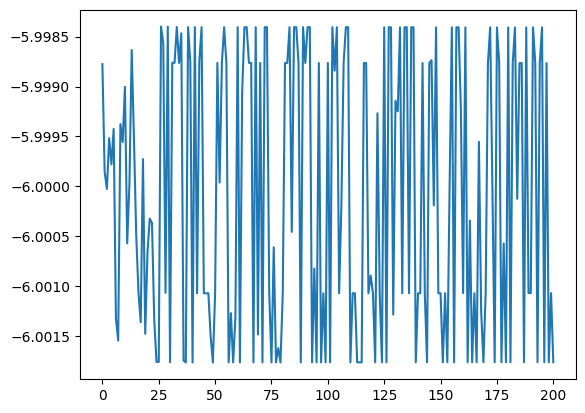

Phi from random theta initialization: [0.35142642+0.00566465j 0.35526049-0.00039473j 0.347629  +0.0047848j
 0.35165566-0.00126026j 0.35553338+0.00135991j 0.35935136-0.00488436j
 0.351633  +0.00045859j 0.35564407-0.00577269j]
Phi that has been learned: [0.35360796-1.86689323e-05j 0.35347561+3.40556546e-05j
 0.35350623+3.20887620e-05j 0.35362375+4.20812444e-05j
 0.35362377+4.20811563e-05j 0.35350619+3.20663587e-05j
 0.35347562+3.40582902e-05j 0.35360793-1.86275982e-05j]


In [134]:
N = 3
M = 6
J = 0
g = 2
sample_size = 300
thermalization_step = 30
random_theta = initialize_random_theta(N,M)
learning_rate = 0.01
phi = np.zeros((2**N),dtype=np.complex_)
for i in range(2**N):
    phi[i] = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(i,N)), random_theta)


learned_theta, losses = gradient_descent(random_theta, N, M, J, g, sample_size, thermalization_step, learning_rate, max_iter = 200, autoTerminate = False)
plt.plot(losses)
plt.show()

minimized_phi = np.zeros((2**N),dtype=np.complex_)
for i in range(2**N):
    minimized_phi[i] = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(i,N)), learned_theta)

phi = phi/np.sqrt(np.vdot(phi,phi))
minimized_phi = minimized_phi/np.sqrt(np.vdot(minimized_phi,minimized_phi))
print(f'Phi from random theta initialization: {phi}')
print(f'Phi that has been learned: {minimized_phi}')

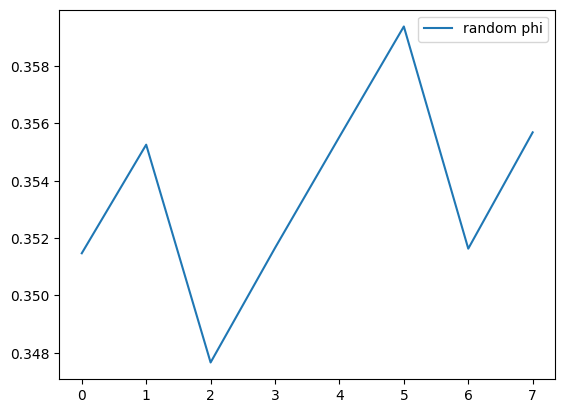

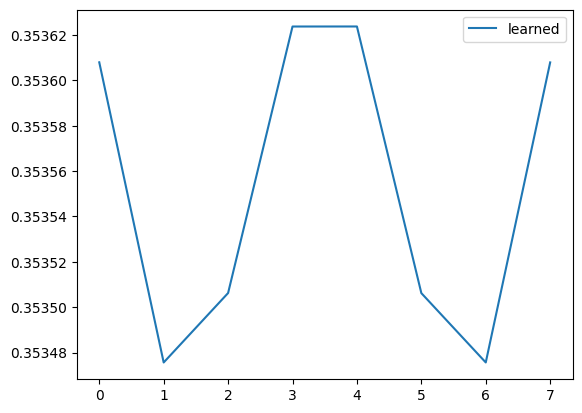

In [136]:
phi = phi/np.sqrt(np.vdot(phi,phi))
minimized_phi = minimized_phi/np.sqrt(np.vdot(minimized_phi,minimized_phi))

x = np.linspace(0, len(phi)-1, len(phi))
y = np.abs(phi)
plt.plot(x, y, label="random phi")
plt.legend()
plt.show()

y = np.abs(minimized_phi)
plt.plot(x, y, label="learned")
plt.legend()
plt.show()

Iteration 100, Loss: -0.9533333333333334, Loss Change: -0.11333333333333329
Iteration 200, Loss: -1.9333333333333333, Loss Change: -0.006666666666666821


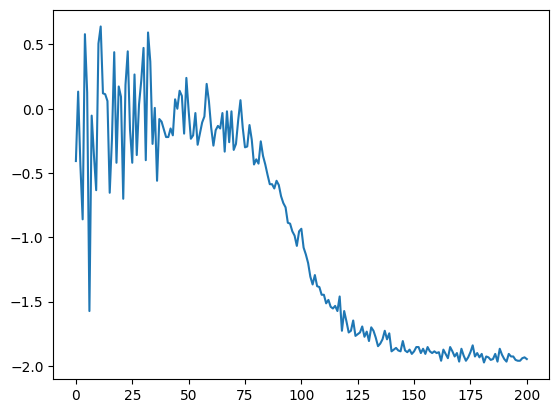

Phi from random theta initialization: [0.35635615+0.00222433j 0.35277352-0.00357913j 0.35747224+0.00326391j
 0.35424783-0.00231007j 0.35310002+0.0025087j  0.34943749-0.00322426j
 0.35409038+0.00363971j 0.35078466-0.00186503j]
Phi that has been learned: [0.98937807+3.21112956e-02j 0.08838239-1.20791833e-02j
 0.05981158+1.43413194e-02j 0.01479106-5.38807129e-04j
 0.08668724-8.20269505e-03j 0.01682234+5.21061975e-04j
 0.01424683-3.77691396e-04j 0.00848723+5.93459406e-05j]


In [137]:
N = 3
M = 6
J = -1
g = 0
sample_size = 300
thermalization_step = 30
random_theta = initialize_random_theta(N,M)
learning_rate = 0.01

phi = np.zeros((2**N),dtype=np.complex_)
for i in range(2**N):
    phi[i] = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(i,N)), random_theta)
    
learned_theta, losses = gradient_descent(random_theta, N, M, J, g, sample_size, thermalization_step, learning_rate, max_iter = 200, autoTerminate = False)
plt.plot(losses)
plt.show()


minimized_phi = np.zeros((2**N),dtype=np.complex_)
for i in range(2**N):
    minimized_phi[i] = rbm_phi_theta(convert_str2_rbm_state(convert2_bin(i,N)), learned_theta)

phi = phi/np.sqrt(np.vdot(phi,phi))
minimized_phi = minimized_phi/np.sqrt(np.vdot(minimized_phi,minimized_phi))
print(f'Phi from random theta initialization: {phi}')
print(f'Phi that has been learned: {minimized_phi}')

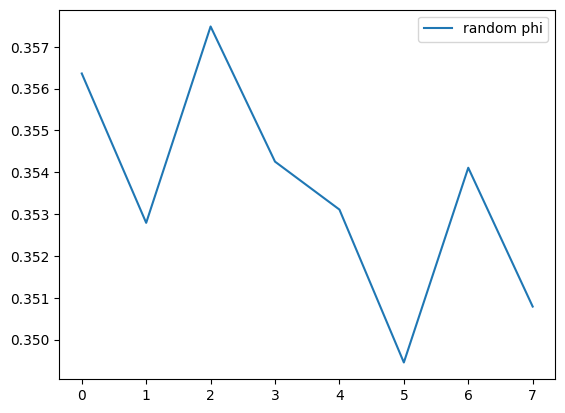

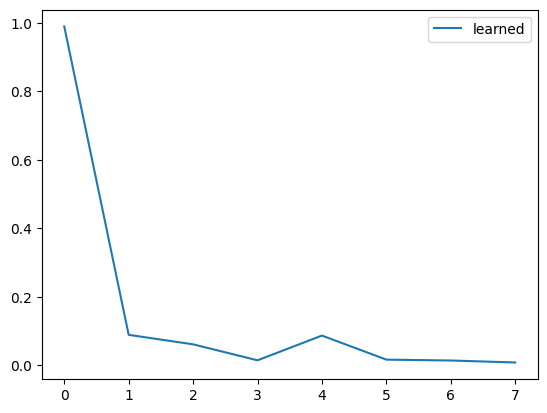

In [138]:
phi = phi/np.sqrt(np.vdot(phi,phi))
minimized_phi = minimized_phi/np.sqrt(np.vdot(minimized_phi,minimized_phi))

x = np.linspace(0, len(phi)-1, len(phi))
y = np.abs(phi)
plt.plot(x, y, label="random phi")
plt.legend()
plt.show()

y = np.abs(minimized_phi)
plt.plot(x, y, label="learned")
plt.legend()
plt.show()